## Imports   

In [1]:
import sys
print(sys.version_info)

import os
import cv2
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import configparser
import tensorflow as tf
import time
import itertools
from glob import glob
from pathlib import Path
from ast import literal_eval
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Cropping2D, Dropout, Conv2D, concatenate, TimeDistributed, CuDNNLSTM, LSTM, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy

import tensorflow.keras.backend as K

# import pydotplus

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)
1.10.0


## Helper functions


In [2]:
hlc_one_hot = { 0: [1,0,0], 1:[0,1,0], 2:[0,0,1] }
#hlc_one_hot = { 1: [1,0,0,0], 2:[0,1,0,0], 3:[0,0,1,0], 4:[0,0,0,1]}

def flatten_list(items_list):
    """ Removes the episode dimension from a list of data points """
    ret = []
    for items in items_list:
        for item in items:
            ret.append(item)        
    return ret      

# Custom loss function 
def weighted_mse(y_true, y_pred, weight_mask):
    """ 
    Custom loss fucntion, different weigted loss to steer/throttle 
    Used when all outputs is evaluated by same loss function 
    """
    return K.mean(K.square(y_pred - y_true)*weight_mask, axis=-1)

def root_mean_squared_error(y_true, y_pred):
    """ Custom loss function, RMSE """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def steer_loss():
    """ Loss function for steering, RMSE """
    def custom(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred)
    return custom

def get_hlc_one_hot(hlc):
    """ One-hot encode HLC values """
    return hlc_one_hot[hlc]

def sine_encode(angle):
    """ Encode steering angle as sine wave """
    angle_max = 1
    N = 10
    ret = []
    
    for i in range(1,N+1,1):
        Y = np.sin(((2*np.pi*(i-1))/(N-1))-((angle*np.pi)/(2*angle_max)))
        ret.append(Y)
    
    return np.array(ret)

def create_input_dict():
    return {
        "forward_imgs": [],
        "hlcs" : [],
    }

def create_target_dict():
    return {
        "steer" : [],
        "throttle": [],
    }

def split_dict(dictionary, split_pos):
    """ Split data into training and validation """
    train_dict = {}
    val_dict = {}
    
    for key in dictionary:
        train_dict[key] = dictionary[key][:split_pos]
        val_dict[key] = dictionary[key][split_pos:]
    
    return train_dict, val_dict
"""
def adjust_hlcs(hlcs, info_signals):
    Randomly adjust HLC backwards, 
    such that the HLC data is given before the car is in the intersection 
    
    # Iterate over all episodes 
    for e in range(len(hlcs)): 
        active_change_hlc = None
        changed = 0
        adjust_num = random.randint(20, 40)
        # Iterate over all hlcs in episode 
        for i in range(len(hlcs[e])-2,-1, -1):
            next_hlc = np.argmax(hlcs[e][i+1]) + 1 
            current_hlc = np.argmax(hlcs[e][i]) +1 
            if active_change_hlc == False:
                active_change_hlc = None
                continue

            if active_change_hlc is None:
                if next_hlc == 1 or next_hlc == 2 or next_hlc == 3:                     
                    if current_hlc == 4: 
                        active_change_hlc = hlcs[e][i+1]
            if active_change_hlc is not None: 
                hlcs[e][i] = active_change_hlc
                if info_signals[e][i][2] != 0: 
                    changed += 1
                if changed == adjust_num:
                    active_change_hlc = False
                    changed = 0 
    return hlcs 
"""
#### BALANCING DATA - Helper functions #### 
def get_hlc_dist_label(hlc): 
    " Get distributions of HLC in data "
    if hlc == 0: 
        return "left"
    elif hlc == 2:
        return "right"
    elif hlc == 1:
        return "straight"
    
def get_speed_dist_label(speed): 
    """ Get distributions of speed in data """

    if speed < 0.001: 
        return "low_speed"
    else: 
        return "high_speed"
    
def get_speed_limit_dist_label(speed_limit): 
    """ Get distributions of speed limits in data """

    speed_limit = round(speed_limit, 1)
    if speed_limit == 0.3: 
        return "30km/h"
    elif speed_limit == 0.6: 
        return "60km/h"
    elif speed_limit == 0.9: 
        return "90km/h"
    
def get_percentage_dist(dist): 
    """ Get distribution of data in percentage """
    N = dist["traffic_light"]["red"] + dist["traffic_light"]["green"]
    for dist_key in dist:
        for key, dist_val in dist[dist_key].items(): 
            dist[dist_key][key] = dist_val/N 
    return dist 

def get_drop_num(tot_num, num, keep_fraction):
    """ Calculates how many datasamples one should drop to get the right amount of data samples """
    return int((num - keep_fraction*tot_num)/(1-keep_fraction))


def shuffle_data(inputs_flat, targets_flat):
    # Shuffle
    indices = np.arange(len(inputs_flat["forward_imgs"]))
    np.random.shuffle(indices)
    
    for key in inputs_flat: 
        inputs_flat[key] = np.array(inputs_flat[key])[indices]
        
    for key in targets_flat: 
        targets_flat[key] = np.array(targets_flat[key])[indices]

    return inputs_flat, targets_flat
         

## Data Augmentations 
- Lightness
- Hue 
- Gaussian Blur
- Shadows 
- Rain

Original image


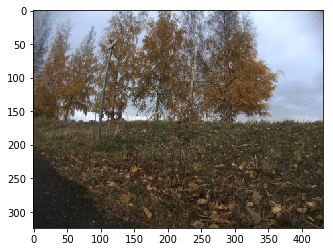

Gaussian


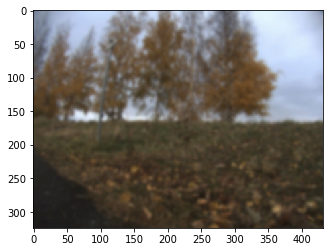

Rain


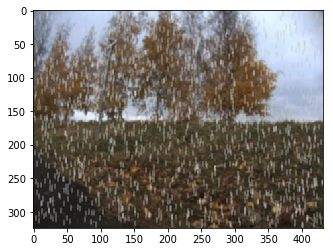

Shadows


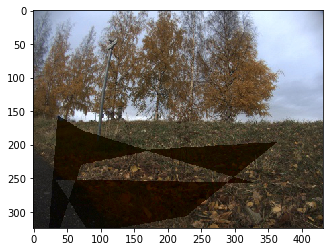

Lightness


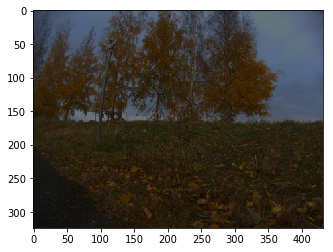

Hue  0


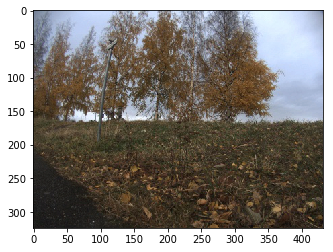

Hue  10


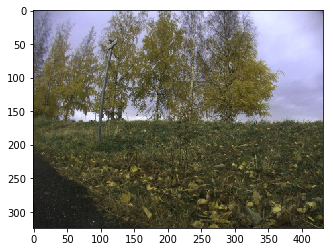

Hue  20


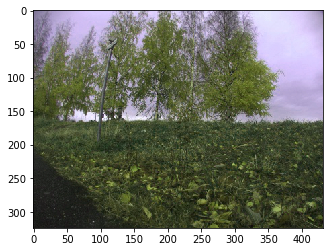

Hue  30


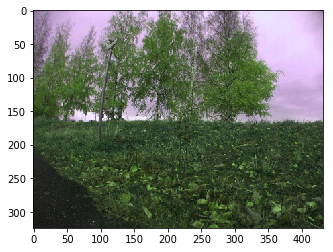

Hue  40


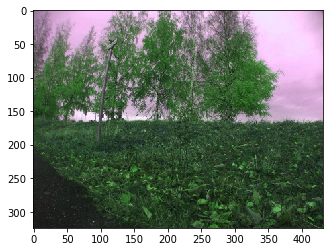

Hue  50


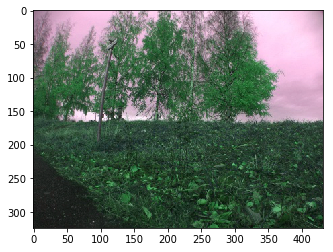

Hue  60


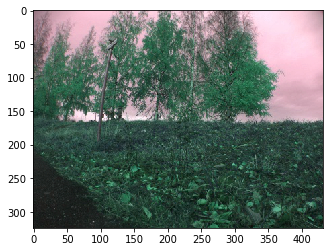

Hue  70


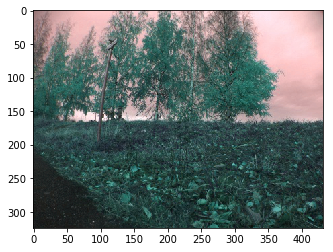

Hue  80


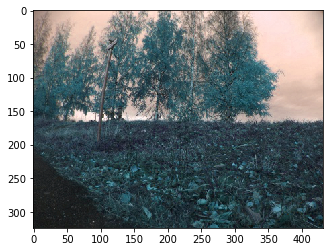

Hue  90


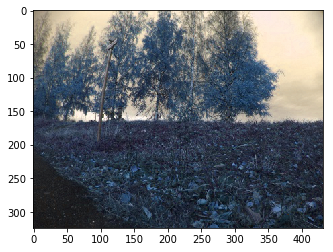

Hue  100


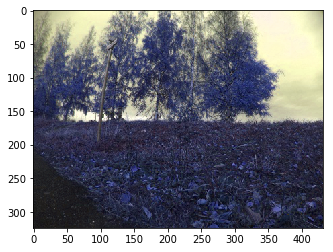

Hue  110


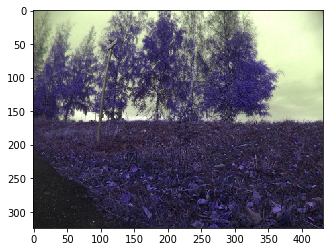

Hue  120


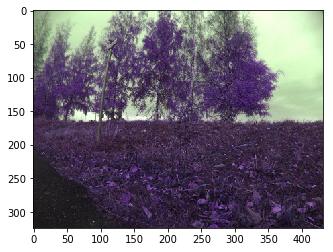

Hue  130


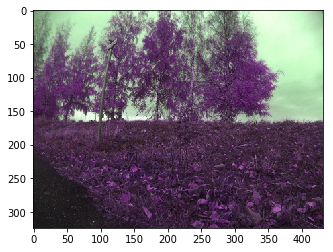

Hue  140


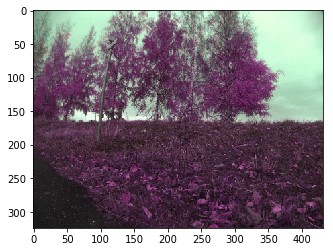

Hue  150


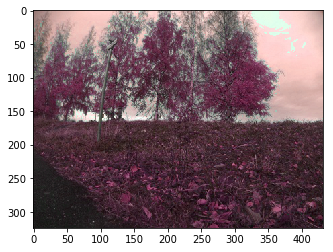

Hue  160


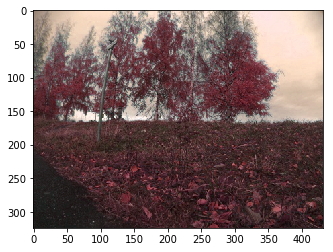

Hue  170


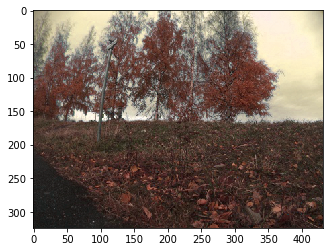

Hue  180


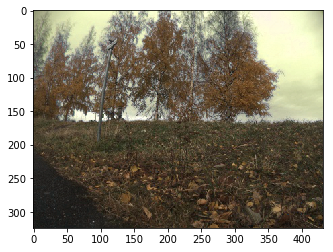

Hue  190


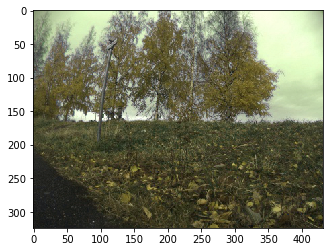

Hue  200


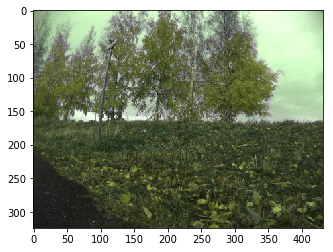

Hue  210


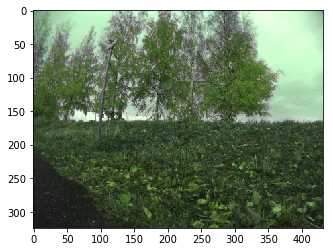

Hue  220


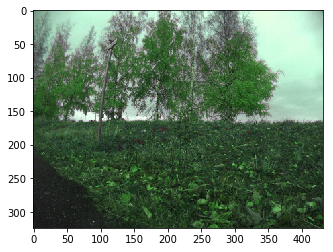

Hue  230


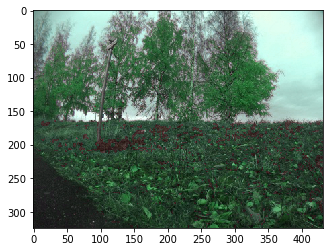

Hue  240


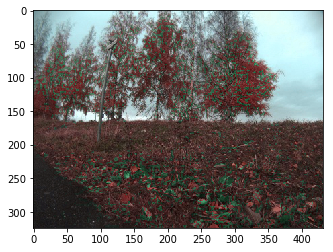

Hue  250


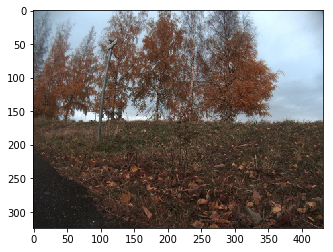

In [3]:
def show_image(lab_img): 
    bgr_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR) 
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB) 
    plt.imshow(rgb_img)
    plt.show()

    
def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def generate_random_lines(imshape,slant,drop_length):    
    drops=[]    
    for i in range(1500): 
        ## If You want heavy rain, try increasing this        
        if slant<0:            
            x= np.random.randint(slant,imshape[1])        
        else:            
            x= np.random.randint(0,imshape[1]-slant)        
        y= np.random.randint(0,imshape[0]-drop_length)        
        
        drops.append((x,y))    
    return drops 

def change_light(bgr_img, light_coeff, debug=False):
    
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB) 
    lab_img[:,:,0] = np.minimum(lab_img[:,:,0]*light_coeff, 255)
    if debug: 
        show_image(lab_img)
    
    return np.array(lab_img, dtype = np.uint8)
    
def change_hue(bgr_img, hue_coeff, debug=False): 
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV) 
    hsv_img[:,:,0] = (hsv_img[:,:,0]+hue_coeff)%255   
    
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR) 
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    
    if debug: 
        show_image(lab_img)
    return np.array(lab_img, dtype = np.uint8)
           

def add_rain(bgr_img, debug=False):     
    bgr_img = np.copy(bgr_img)
    imshape = bgr_img.shape    
    slant_extreme = 10   
    slant= 0 #np.random.randint(-slant_extreme,slant_extreme)     
    drop_length=7
    drop_width=1   
    drop_color=(200,200,200) ## a shade of gray   
    rain_drops= generate_random_lines(imshape,slant,drop_length)        
    for rain_drop in rain_drops:        
        cv2.line(bgr_img,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)    
    bgr_img= cv2.blur(bgr_img,(3,3)) ## rainy view are blurry         
    
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)

    if debug: 
        show_image(lab_img)
    
    return np.array(lab_img, dtype = np.uint8)

    

def add_shadow(bgr_img,no_of_shadows=1, debug=False):
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB) 
    mask = np.zeros_like(lab_img) 
    img_shape = lab_img.shape
    vertices_list= generate_shadow_coordinates(img_shape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    lab_img[:,:,0][mask[:,:,0]==255] = lab_img[:,:,0][mask[:,:,0]==255]*0.2   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    
    if debug: 
        show_image(lab_img)
    
    return np.array(lab_img, dtype = np.uint8)

def gaussian_blur(bgr_img, amount=3, debug=False):
    bgr_img = cv2.GaussianBlur(bgr_img,(amount,amount),0)
    lab_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    if debug: 
        show_image(lab_img)
    
    return np.array(lab_img, dtype = np.uint8)

print_aug = True  

if print_aug: 
    test_path = "/home/audun/Fordypningsprosjekt/SPURV_models/dataset/closed_road_eberg/2019-10-23T143120/images/150.jpg"
    #test_path = "dataset/etron/Town04/ClientAP/cars_no_rain_noise5/2019-06-18_18-23-14/imgs/forward_center_rgb_00000082.png"
    #test_path = "dataset/etron/Town04/ClientAP/cars_no_rain_noise5/2019-06-18_18-17-14/imgs/forward_right_rgb_00000062.png"
    bgr_img = cv2.imread(test_path)
    print("Original image")
    show_image(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB))

    print("Gaussian")
    blur_img = gaussian_blur(bgr_img, amount=11, debug=True)

    print("Rain")
    rain_img = add_rain(bgr_img, debug=True)

    print("Shadows")
    shadow_img = add_shadow(bgr_img, debug=True)

    print("Lightness")
    light_img = change_light(bgr_img, 0.5, debug=True)

    for i in np.arange(0, 255, 10):
        print("Hue ", i)
        hue_img = change_hue(bgr_img, i, debug=True)


## Load driving logs
- Loads data from all csv file in a lits of folders 
- Stores the data in a input dictionary and a target dictionary 
- Normalizes and coverts data to correct format 
- Does not use side cameraes for lane change data


In [4]:
import random
def get_path(episode_path, image_path):
    return str(episode_path / Path("images") / image_path.split("/")[-1])

def load_driving_logs(dataset_folders, steering_correction):
    """ 
    input: 
        dataset_folders: list of paths to folders to load data from 
        steering_correction: float, adjusts steering angles of forward facing side cameras 
        
    Loads data from all csv file in a lits of folders 
    Stores the data in a input dictionary and a target dictionary 
    Normalizes and coverts data to correct format 
    Does not use side cameraes for lane change data
    
    return: 
        inputs: dictionary of all input data (image paths, info signals, HLCs, control signals)
        targets: dictionary of all target data (steer, throttle)
    """
    img_paths_center = []
    
    
    inputs = create_input_dict()
    
    targets = create_target_dict()
    # Loads data 
    for folder in dataset_folders:
        folder_path = Path("dataset") / folder
        for episode in glob(str(folder_path / "*")):
            
            
            temp_forward = {"center": [], "left": [], "right": []}
            temp_hlcs =  {"center": [], "left": [], "right": []}

            temp_steer =  {"center": [], "left": [], "right": []}
            temp_throttle = {"center": [], "left": [], "right": []}
                
            episode_path = Path(episode)

            df = pd.read_csv(str(episode_path / "driving_log.csv"))
            for index, row in df.iterrows():
                if index == 0: 
                    continue 
                                                        
                steer = row["angle"]
                throttle = row["speed"]
                                
                hlc = row["high_level_command"]
                #if hlc == 0 or hlc == -1:
                #    hlc = 4
                hlc = get_hlc_one_hot(hlc)
                
                temp_forward["center"].append(get_path(episode_path, row["image_path"]))              
                temp_steer["center"].append(steer)
                temp_throttle["center"].append(throttle)
                temp_hlcs["center"].append(hlc)
                                
                    
            inputs["forward_imgs"].append(temp_forward["center"])
                        
            inputs["hlcs"].append(temp_hlcs["center"])
                        
            targets["steer"].append(temp_steer["center"])
            
            targets["throttle"].append(temp_throttle["center"])


    print("Done, {:d} episode(s) loaded.".format(len(inputs["forward_imgs"])))

    return(inputs, targets)


## Plot Data 

In [5]:
def plot_data(dist, title=""):
    """ Plots distribution of HLC, speed and traffic lights """
    print("Plotting...")
    tot_num = 0
    
    fig = plt.figure(figsize=(16,6))

    # HLC
    labels =["Left", "Right", "Straight"]
    sizes = [dist["hlc"]["left"], dist["hlc"]["right"], dist["hlc"]["straight"]]
    
    ax1 = fig.add_subplot(1,4,1)
    wedges, texts, autotexts = ax1.pie(sizes, autopct='%.1f%%')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    ax1.set_title("Distrubution of HLC")
    ax1.legend(wedges,labels, loc="best")
    ax1.axis('equal')
    

    # Speed
    labels =["Low Speed", "High Speed"]
    sizes = [dist["speed"]["low"], dist["speed"]["high"]]
    
    ax2 = fig.add_subplot(1,4,2)
    wedges, texts, autotexts = ax2.pie(sizes, autopct='%.1f%%')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax2.set_title("Distrubution of speed")
    ax2.legend(wedges,labels, loc="best")
    ax2.axis('equal')

    # Steering
    labels =["Left", "Straight", "Right"]
    print("Dist: ", dist)
    sizes = [dist["steering"]["left"], dist["steering"]["straight"], dist["steering"]["right"]]
    
    ax2 = fig.add_subplot(1,4,3)
    wedges, texts, autotexts = ax2.pie(sizes, autopct='%.1f%%')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax2.set_title("Distrubution of steering angle")
    ax2.legend(wedges,labels, loc="best")
    ax2.axis('equal')
    

    fig.suptitle(title + ": " + str(tot_num) + " sequences", fontsize=18)
    plt.show()

## Balance Data 

- Get distribution of HLC, speed, speed limit, and traffic lights 
- Balance data for LSTM 

In [6]:
def get_dist(inputs, targets): 
    """ 
        input:
            inputs: dictionary of input data 
            targets: dictionary of result data
                
        return: 
            dist: dictionary of distributions for HLC, speed, angle 
    """
    dist = {
        "hlc": {
            "left": 0,
            "right": 0, 
            "straight": 0,
        },
        "steering": {
            "left": 0, # More than 20 deg left
            "right": 0, # More than 20 deg right
            "straight": 0 # Between left and right
        },
        "speed": {
            "high": 0, #More than 0.5m/s
            "low": 0 #Less than 0.5 m/s
        }

    }
    
    #print("getting dist", inputs, targets)
    # HLC distribution
    for hlcs in inputs["hlcs"]: 
        
        # Iterate over all HLC in sequence 
        for hlc in hlcs: 
            hlc_value = np.argmax(hlc)
            if hlc_value == 0:
                dist["hlc"]["left"] += 1
            elif hlc_value == 1:
                dist["hlc"]["straight"] += 1
            elif hlc_value == 2:
                dist["hlc"]["right"] += 1

            
    # Speed distribution 
    for speed in targets["throttle"]: 
        if speed > 0.5:
            dist["speed"]["high"] +=1 
        else: 
            dist["speed"]["low"] +=1
            
            
    # Steering distribution 
    for angle in targets["steer"]: 
        if angle < -0.1:
            dist["steering"]["left"] +=1 
        elif angle > 0.1:
            dist["steering"]["right"] += 1
        else: 
            dist["steering"]["straight"] +=1         

    return dist   
    

def balance_steering_angle(inputs, targets, dist, target_straight_fraction): 
    """ Balance steer angle such that target fraction is correct """
    
    # Find the steering with least amount of values
    least_vals = min(dist["steering"]["straight"], dist["steering"]["left"], dist["steering"]["right"])
    
    inputs_bal = create_input_dict()
    targets_bal = create_target_dict() 
        
    left_count = 0
    right_count = 0
    forward_count = 0
    
    for i in range(len(inputs["hlcs"])):
        angle = targets["steer"][i]
        is_left = angle < -0.1
        is_right = angle > 0.1
        
        if is_left and left_count >= least_vals:
            continue
        
        elif is_right and right_count >= least_vals:
            continue
        
        elif not is_left and not is_right and forward_count >= least_vals:
            continue
            
        if is_left:
            left_count += 1
        elif is_right:
            right_count += 1
        else:
            forward_count += 1
        
        # Keep 
        for key in inputs_bal: 
            inputs_bal[key].append(inputs[key][i])
        for key in targets_bal: 
            targets_bal[key].append(targets[key][i])

    return inputs_bal, targets_bal 


def balance_data_lstm(inputs, targets, straight_angle_frac=0.2,debug=False, drop=False):
    """ Balance dataset for LSTM data """
    print("Balancing data:")
    
    # Get distribution 
    dist = get_dist(inputs, targets)
    print("dist: ", dist)
    
    inputs_bal = inputs
    targets_bal = targets
    dist_bal = dist 
    
    # Balance steering angle 
    print("   - Balancing steering angle")
    inputs_bal, targets_bal = balance_steering_angle(inputs_bal, targets_bal, dist_bal, straight_angle_frac)
    dist_bal = get_dist(inputs_bal, targets_bal)
    print("dist_bal: ", dist_bal)
    

    # Shuffle
    inputs_bal, targets_bal = shuffle_data(inputs_bal, targets_bal)
    
    if drop: 
        inputs_bal, targets_bal = drop_follow_lane(inputs_bal,targets_bal, 3)
        
    dist_bal = get_dist(inputs_bal, targets_bal)
        
    return inputs_bal, targets_bal, dist_bal

## Drop random data 
Randomly drop data that is follow lane without brake values or turns 

In [7]:
def drop_follow_lane(inputs, targets, keep_every): 
    print("Dropping...")
    
    inputs_dropped = create_input_dict()
    targets_dropped = create_target_dict() 
    

    for i in range(len(inputs["forward_imgs"])): 
        
        
        follow_lane = True 
        # Iterate over all HLC in sequence 
        for hlc in inputs["hlcs"][i]: 
            hlc_value = np.argmax(hlc) + 1 
            # Only mark sequence as follow lane if all hlcs are follow lane  
            if hlc_value != 4:
                follow_lane = False 
                break
                
        steer = targets["steer"][i]
        
        # Only drop if FOLLOW_LANE, no brake, and no turn
        if follow_lane and abs(steer)<0.1:  
            # Drop based on drop_rate 
            
            if np.random.randint(keep_every) != 0: 
                continue

        # Keep 
        for key in inputs_dropped: 
            inputs_dropped[key].append(inputs[key][i])
        for key in targets_dropped: 
            targets_dropped[key].append(targets[key][i])

    return inputs_dropped, targets_dropped 
    

# LSTM

## Prepare dataset format

In [8]:
def get_episode_sequences(data, sampling_interval, seq_length):
    sequences = []
    slices = []
    for o in range(sampling_interval+1):
        slices.append(data[o::sampling_interval+1])
    for s in slices:
        for o in range(0,len(s)):
            if o + seq_length <= len(s):
                sequences.append(s[o:o+seq_length])
    return sequences

def prepare_dataset_lstm(inputs, targets, sampling_interval, seq_length):
    
    inputs_flat = create_input_dict()
    targets_flat = create_target_dict()
    
    for e in range(len(inputs["forward_imgs"])):
        [inputs_flat["forward_imgs"].append(sequence) for sequence in get_episode_sequences(inputs["forward_imgs"][e],sampling_interval, seq_length)]
        [inputs_flat["hlcs"].append(sequence) for sequence in get_episode_sequences(inputs["hlcs"][e],sampling_interval, seq_length)]
        [targets_flat["steer"].append(sequence[-1]) for sequence in get_episode_sequences(targets["steer"][e],sampling_interval, seq_length)]
        [targets_flat["throttle"].append(sequence[-1]) for sequence in get_episode_sequences(targets["throttle"][e],sampling_interval, seq_length)]

    
    # Shuffle
    inputs_flat, targets_flat = shuffle_data(inputs_flat, targets_flat)
    
    return(inputs_flat, targets_flat)
        

## Define model

In [9]:
def get_lstm_model(seq_length, sine_steering=False, print_summary=True):
    forward_image_input = Input(shape=(seq_length, 162, 216, 3), name="forward_image_input")
    hlc_input = Input(shape=(seq_length,3), name="hlc_input")

    x = TimeDistributed(Cropping2D(cropping=((50,0),(0,0))))(forward_image_input)
    x = TimeDistributed(Conv2D(24,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(36,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(48,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3), activation="relu"))(x)
    conv_output = TimeDistributed(Flatten())(x)

    x = concatenate([conv_output, hlc_input])
    
    x = TimeDistributed(Dense(100, activation="relu"))(x)
    x = CuDNNLSTM(10, return_sequences = False)(x)
    steer_dim = 1 if not sine_steering else 10
    steer_pred = Dense(steer_dim, activation="tanh", name="steer_pred")(x)
    
    x = TimeDistributed(Cropping2D(cropping=((50,0),(0,0))))(forward_image_input)
    x = TimeDistributed(Conv2D(24,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(36,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(48,(5,5),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3),strides=(2,2), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3), activation="relu"))(x)
    x = TimeDistributed(Conv2D(64,(3,3), activation="relu"))(x)
    conv_output = TimeDistributed(Flatten())(x)

    x = concatenate([conv_output, hlc_input])
    
    x = TimeDistributed(Dense(100, activation="relu"))(x)
    x = CuDNNLSTM(10, return_sequences = False)(x)
    throtte_pred = Dense(1, name="throttle_pred")(x)
    
    model = Model(inputs=[forward_image_input, hlc_input], outputs=[steer_pred,throtte_pred])

    if print_summary: 
        model.summary()
    
    return model

# Training

## Define generator

In [10]:
class generator(Sequence):
    def __init__(self, inputs, targets, batch_size, validation=False, sine_steering=False):
        self.inputs = inputs
        self.targets = targets
        self.batch_size = batch_size
        self.validation = validation
        self.sine_steering = sine_steering
        
        random.seed() 
        # Convert to np array
        for key in inputs: 
            inputs[key] = np.array(self.inputs[key])

        for key in targets: 
            targets[key] = np.array(self.targets[key])

    def __len__(self):
        return int(np.ceil(len(self.inputs["forward_imgs"]) / float(self.batch_size)))

    def __getitem__(self, idx):
        subset = np.arange(idx * self.batch_size,min((idx + 1) * self.batch_size,len(self.inputs["forward_imgs"])))
        forward_imgs = []
        read_images = [[cv2.resize(cv2.imread(path), None, fx=0.5, fy=0.5) for path in seq] for seq in self.inputs["forward_imgs"][subset]]
        steer_pred = self.targets["steer"][subset]
        if self.sine_steering:
            steer_pred = np.array([sine_encode(steer) for steer in steer_pred])
        if not self.validation: 
            augment = random.randint(0,2)
            if augment == 0: 
                augment_type = random.randint(0,4)
                
                # Lightness 
                if augment_type == 0: 
                    light_coeff = random.random()*0.9+0.5
                    for seq in read_images:
                        forward_imgs.append([change_light(image, light_coeff=light_coeff) for image in seq])
                # Hue 
                elif augment_type == 1:
                    hue_coeff = random.random()*1.4 + 0.2
                    for seq in read_images:
                        forward_imgs.append([change_hue(image, hue_coeff=hue_coeff) for image in seq])
                # Rain 
                elif augment_type == 2:
                    for seq in read_images:
                        forward_imgs.append([add_rain(image) for image in seq])
                
                # Shadows 
                elif augment_type == 3:
                    for seq in read_images:
                        forward_imgs.append([add_shadow(image) for image in seq])
                # Gaussian blur 
                elif augment_type == 4:
                    for seq in read_images:
                        forward_imgs.append([gaussian_blur(image) for image in seq])
            else: 
                for seq in read_images:
                    forward_imgs.append([cv2.cvtColor(image,cv2.COLOR_BGR2LAB) for image in seq])
        else:
            for seq in read_images:
                forward_imgs.append([cv2.cvtColor(image,cv2.COLOR_BGR2LAB) for image in seq])

        forward_imgs = np.array(forward_imgs)/255.0 - 0.5
        return {
            "forward_image_input": np.array(forward_imgs), 
            "hlc_input": self.inputs["hlcs"][subset]
        }, {
            "steer_pred": steer_pred,
            "throttle_pred": self.targets["throttle"][subset],
        }
            


## Parameters

In [25]:
val_split = 0.8
adjust_hlc = False 
balance_data = False 


epochs_list = [100]
dataset_folders_lists = [["glos_cycle_straight_mini"], ["glos_cycle_manual_noise_mini"], ["glos_cycle_noise_mini"]]
"""dataset_folders_lists = [([
    "etron/Town01/ClientAP/no_cars_no_rain",
    "etron/Town01/ClientAP/no_cars_no_rain_noise15",
    "etron/Town01/ClientAP/no_cars_rain_noise10",
    "etron/Town01/ClientAP/cars_no_rain_noise15",
    "etron/Town01/ClientAP/cars_rain_noise10",    
], [
    "etron/Town04/ClientAP/no_cars_no_rain", 
    "etron/Town04/ClientAP/no_cars_rain_noise5", 
    "etron/Town04/ClientAP/cars_no_rain_noise5", 
    "etron/Town04/ClientAP/cars_rain_noise5", 
    "etron/Town01/ClientAP/brake_all_weather_noise15",
    "etron/Town01/ClientAP/brake_all_weather",
])]"""


steering_corrections = [0.05]

batch_sizes = [32]

sampling_intervals = [3]

seq_lengths = [10]

sine_steering_list = [False]

balance_data_list = [False]

        

## Training loop

Name of model test: glos_cycle_dataset_manual_and_triangular
Done, 3 episode(s) loaded.
Initiate training loop with the following parameters:
---
epochs:			100
dataset folders:	['glos_cycle_manual_noise_mini', 'glos_cycle_noise_mini']
steering correction:	0.05
batch size:		32
balance:		False
sine_steer:		False
sampling interval:	3
seq lenght: 		10


---
Training set size: 42599
Validation set size: 10650
Epoch 1/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.3704 - steer_pred_loss: 0.3691 - throttle_pred_loss: 0.0014
Epoch 00001: saving model to models/glos_cycle_dataset_manual_and_triangular/2019-11-15_10-12-49/01_s0.3053_t0.0005.h5
1331/1331 [==============================] - 703s 528ms/step - loss: 0.3704 - steer_pred_loss: 0.3690 - throttle_pred_loss: 0.0014 - val_loss: 0.3058 - val_steer_pred_loss: 0.3053 - val_throttle_pred_loss: 4.8439e-04
Epoch 2/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.2861 - steer_pred_loss: 0.2856 - throttle_pred

Epoch 15/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.1812 - steer_pred_loss: 0.1810 - throttle_pred_loss: 1.9108e-04
Epoch 00015: saving model to models/glos_cycle_dataset_manual_and_triangular/2019-11-15_10-12-49/15_s0.2111_t0.0001.h5
1331/1331 [==============================] - 683s 513ms/step - loss: 0.1812 - steer_pred_loss: 0.1810 - throttle_pred_loss: 1.9104e-04 - val_loss: 0.2112 - val_steer_pred_loss: 0.2111 - val_throttle_pred_loss: 1.2369e-04
Epoch 16/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.1788 - steer_pred_loss: 0.1786 - throttle_pred_loss: 1.8515e-04
Epoch 00016: saving model to models/glos_cycle_dataset_manual_and_triangular/2019-11-15_10-12-49/16_s0.2101_t0.0001.h5
1331/1331 [==============================] - 683s 513ms/step - loss: 0.1788 - steer_pred_loss: 0.1786 - throttle_pred_loss: 1.8503e-04 - val_loss: 0.2102 - val_steer_pred_loss: 0.2101 - val_throttle_pred_loss: 7.2649e-05
Epoch 00016: early stopping
History {'va

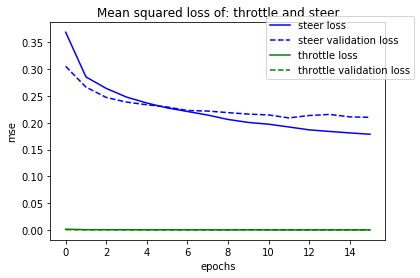






Done, 3 episode(s) loaded.
Initiate training loop with the following parameters:
---
epochs:			100
dataset folders:	['glos_cycle_manual_noise_mini', 'glos_cycle_noise_mini']
steering correction:	0.05
batch size:		32
balance:		False
sine_steer:		True
sampling interval:	3
seq lenght: 		10


---
Training set size: 42599
Validation set size: 10650
Epoch 1/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.3989 - steer_pred_loss: 0.3977 - throttle_pred_loss: 0.0012
Epoch 00001: saving model to models/lstm/2019-11-15_13-16-24/01_s0.3117_t0.0004.h5
1331/1331 [==============================] - 687s 516ms/step - loss: 0.3988 - steer_pred_loss: 0.3976 - throttle_pred_loss: 0.0012 - val_loss: 0.3121 - val_steer_pred_loss: 0.3117 - val_throttle_pred_loss: 4.0615e-04
Epoch 2/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.2943 - steer_pred_loss: 0.2937 - throttle_pred_loss: 5.2782e-04
Epoch 00002: saving model to models/lstm/2019-11-15_13-16-24/02_s0.2733_t0.

Epoch 17/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.1823 - steer_pred_loss: 0.1821 - throttle_pred_loss: 1.3559e-04
Epoch 00017: saving model to models/lstm/2019-11-15_13-16-24/17_s0.2240_t0.0001.h5
1331/1331 [==============================] - 682s 513ms/step - loss: 0.1822 - steer_pred_loss: 0.1821 - throttle_pred_loss: 1.3551e-04 - val_loss: 0.2241 - val_steer_pred_loss: 0.2240 - val_throttle_pred_loss: 1.2631e-04
Epoch 18/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.1787 - steer_pred_loss: 0.1785 - throttle_pred_loss: 1.9727e-04
Epoch 00018: saving model to models/lstm/2019-11-15_13-16-24/18_s0.2224_t0.0002.h5
1331/1331 [==============================] - 683s 513ms/step - loss: 0.1787 - steer_pred_loss: 0.1785 - throttle_pred_loss: 1.9717e-04 - val_loss: 0.2226 - val_steer_pred_loss: 0.2224 - val_throttle_pred_loss: 2.1069e-04
Epoch 19/100
1330/1331 [============================>.] - ETA: 0s - loss: 0.1785 - steer_pred_loss: 0.1782 - thr

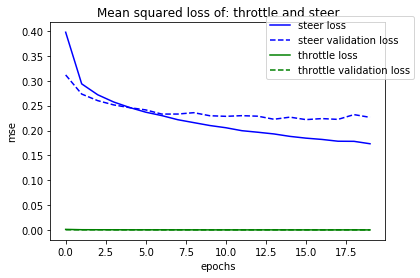

In [27]:
parameter_permutations = itertools.product(epochs_list, 
                                           dataset_folders_lists, 
                                           steering_corrections, 
                                           batch_sizes,
                                           sampling_intervals,
                                           seq_lengths,
                                           sine_steering_list,
                                           balance_data_list)

# Train a new model for each parameter permutation, and save the best models
model_name = input("Name of model test: ").strip()
#balance_data = True if input("Balance data y/[n]: ").lower() == "y" else False 
#drop_data = True if input("Drop data y/[n]: ").lower() == "y" else False 

parameter_permutations_list = []#[p for p in parameter_permutations]
# glos_cycle_full_folders = ["glos_cycle_track_wet_clouded", "glos_cycle_noise_mini"]
glos_cycle_full_folders = ["glos_cycle_manual_noise_mini", "glos_cycle_noise_mini"]
parameter_permutations_list.append([epochs_list[0], 
                                glos_cycle_full_folders, 
                                steering_corrections[0], 
                                batch_sizes[0],
                                sampling_intervals[0],
                                seq_lengths[0],
                                False,
                                False])

parameter_permutations_list.append([epochs_list[0], 
                                glos_cycle_full_folders, 
                                steering_corrections[0], 
                                batch_sizes[0],
                                sampling_intervals[0],
                                seq_lengths[0],
                                True,
                                False])



for parameters in parameter_permutations_list:
    # Get parameters
    epochs, dataset_folders, steering_correction, batch_size, sampling_interval, seq_length, sine_steering, balance_data = parameters
    parameters_string = ("epochs:\t\t\t{}\ndataset folders:\t{}\nsteering correction:\t{}\nbatch size:\t\t{}\nbalance:\t\t{}\nsine_steer:\t\t{}\nsampling interval:\t{}\nseq lenght: \t\t{}\n\n"
                         .format(epochs, str(dataset_folders), steering_correction, batch_size, balance_data, sine_steering, sampling_interval, seq_length))
    
    
    #town1_dataset_folders, town4_dataset_folders = dataset_folders

    # Prepare for logging
    timestamp = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime(time.time()))
    path = Path('models') / model_name / timestamp
    if not os.path.exists(str(path)):
        os.makedirs(str(path))
        
    # Save parmeters to disk
    with open(str(path / "parameters.txt"), "w") as text_file:
        text_file.write(parameters_string)
    
    # Save config file to disk 
    model_name = "lstm"
    config = configparser.ConfigParser()
    config["ModelConfig"] = {'Model': model_name,'sequence_length': seq_length,'sampling_interval': sampling_interval}
    with open(str(path/'config.ini'), 'w') as configfile:
        config.write(configfile)
    
    # Load drive logs and paths
    inputs, targets = load_driving_logs(dataset_folders, steering_correction)
    inputs_flat, targets_flat = prepare_dataset_lstm(inputs, targets, sampling_interval, seq_length)

    # Balance data 
    if balance_data:
        # Plot data before balancing 
        title_before = "Before Balancing"
        #print("inputs_flat", inputs_flat)
        plot_data(get_dist(inputs_flat, targets_flat), title=title_before)

        # Balance data 
        inputs_flat, targets_flat, dist_bal1 = balance_data_lstm(inputs_flat, targets_flat)

        # Plot data after balancing 
        title_after = "After Balancing"
        plot_data(dist_bal1, title=title_after)


    inputs_flat_dict = create_input_dict() 
    targets_flat_dict = create_target_dict() 

    for key in inputs_flat: 
        inputs_flat_dict[key] = inputs_flat[key] 

    for key in targets_flat: 
        targets_flat_dict[key] = targets_flat[key]
                
    # Shuffle data 
    inputs_flat, targets_flat = shuffle_data(inputs_flat, targets_flat)           
    
    # Split into val and train
    split_pos = int(val_split*len(inputs_flat["forward_imgs"]))
    inputs_train, inputs_val = split_dict(inputs_flat, split_pos)
    targets_train, targets_val = split_dict(targets_flat, split_pos)

    # Print training info 
    train_num = len(inputs_train["forward_imgs"])
    val_num = len(inputs_val["forward_imgs"])
    print("Initiate training loop with the following parameters:")
    print("---")
    print(parameters_string)
    print("---")
    print("Training set size: " + str(train_num))
    print("Validation set size: " + str(val_num))

    # Get model
    model = get_lstm_model(seq_length, print_summary=False, sine_steering=sine_steering)

    
    # Compile model 
    model.compile(loss=[steer_loss(), mean_squared_error] , optimizer=Adam())

    checkpoint_val = ModelCheckpoint(str(path / ('{epoch:02d}_s{val_steer_pred_loss:.4f}_t{val_throttle_pred_loss:.4f}.h5')), monitor='val_loss', verbose=1, save_best_only=False,mode="min")
    
    # Create image of model architecture 
    #plot_model(model, str(path/'model.png'))
    
    steps = int(train_num/batch_size)
    steps_val = int(val_num/batch_size)
     
        
    # Define early stopping params
    es = EarlyStopping(monitor='val_steer_pred_loss', mode='min', verbose=1, patience=8)
    
    # Train model
    history_object = model.fit_generator(
        generator(inputs_train, targets_train, batch_size, sine_steering=sine_steering),
        validation_data=generator(inputs_val, targets_val, batch_size, validation=True, sine_steering=sine_steering),
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint_val, es],
        steps_per_epoch=steps,
        validation_steps = steps_val,
        use_multiprocessing = True,
        workers=10
    )
    
    # Prepare plot and save it to disk
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    print("History", history_object.history)
    ax.plot(history_object.history['steer_pred_loss'], color="blue")
    ax.plot(history_object.history['val_steer_pred_loss'], color="blue", linestyle="--")
    ax.plot(history_object.history['throttle_pred_loss'], color="green")
    ax.plot(history_object.history['val_throttle_pred_loss'], color="green", linestyle="--")

    ax.set_title("Mean squared loss of: throttle and steer")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mse")

    lgd = ax.legend(['steer loss', 
               'steer validation loss',
               'throttle loss', 
               'throttle validation loss'], bbox_to_anchor=(1.1, 1.05))
    
    plt.show()
    fig.savefig(str(path / 'loss.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('\n\n\n\n')